<a href="https://colab.research.google.com/github/wfreinhart/sdmm-regression/blob/main/notebooks/figure11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# generate blender files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_prefix = '/content/drive/Shareddrives/Polymers-Data'

Mounted at /content/drive


In [ ]:
try:
    import MDAnalysis
except:
    !pip install MDAnalysis==1.0.0

     |████████████████████████████████| 19.6 MB 12.2 MB/s 
     |████████████████████████████████| 2.3 MB 62.9 MB/s 
     |████████████████████████████████| 2.1 MB 58.2 MB/s 
     |████████████████████████████████| 374 kB 70.4 MB/s 
     |████████████████████████████████| 40 kB 22 kB/s 
  Created wheel for MDAnalysis: filename=MDAnalysis-1.0.0-cp37-cp37m-linux_x86_64.whl size=4549189 sha256=635fd82f264fdef5be4baf4af460e25f7cf34171b36c2eb16e2fcb9b6e8753fa
  Stored in directory: /root/.cache/pip/wheels/e6/2c/3a/d2b056f1f24662cf00b6a298bf66856addd3fe942d7426717a
Successfully built MDAnalysis


In [ ]:
import MDAnalysis
from MDAnalysis.lib import distances, mdamath
import numpy as np

def read_cg(filename, n_cg, frame=-1):
    traj = MDAnalysis.Universe(filename)
    traj.trajectory[int(frame)]  # go to end of trajectory
    xyz = traj.atoms.positions
    _, types = np.unique(traj.atoms.types, return_inverse=True)
    box = traj.dimensions

    f = distances.transform_RtoS(xyz, box)

    f_cg = f[0::n_cg]
    types_cg = types[0::n_cg]
    for i in range(1, n_cg):
        vec = f[i::n_cg] - f[0::n_cg]
        vec -= np.round(vec)
        f_cg += vec
        types_cg += types[i::n_cg]

    f_cg -= np.round(f_cg)
    xyz_cg = distances.transform_StoR(f_cg, box) + 0.5 * box[:3]
    _, types_cg = np.unique(types_cg, return_inverse=True)

    return xyz_cg, box, types_cg

In [ ]:
import colorsys
import os
import pickle


def bitshift_rgb(rgb):
    colors = np.array([(red << 16) + (green << 8) + blue for red, green, blue in rgb.astype(int)], dtype=np.uint32)
    return colors


def unshift_rgb(colors):
    red = [(c & 16711680) >> 16 for c in colors]
    green = [(c & 65280) >> 8 for c in colors]
    blue = [c & 255 for c in colors]
    return np.vstack([red, green, blue]).T


class RGBColorMapper(object):
    def __init__(self):
        self.buffer = 0.0
        self.fmin = np.array([-100, -100, -100])
        self.fmax = np.array([ 100,  100,  100])
        self.range = np.ones(3)

    def fit(self, raw_coords):
        self.range = raw_coords.max(axis=0) - raw_coords.min(axis=0)
        self.fmin = raw_coords.min(axis=0) - self.buffer * self.range  # give a buffer zone
        self.fmax = raw_coords.max(axis=0) + self.buffer * self.range  # give a buffer zone

    def transform(self, raw_coords):
        rgb = (raw_coords - self.fmin) / self.range
        # rgb = rgb * 0.90 + 0.10  # clamp the brightness
        colors = bitshift_rgb(255 * rgb)

        return colors

    def fit_transform(self, raw_coords):
        self.fit(raw_coords)
        return self.transform(raw_coords)


with open(os.path.join(drive_prefix, 'umap-reducers', 'umap-reducer-AB-1024-data.pkl'), 'rb') as fid:
    buffer = pickle.load(fid)

cm = RGBColorMapper()
c = cm.fit_transform(buffer['embedding_'])

In [ ]:
import pandas as pd
from tqdm import notebook


for target_dir in ['gru-cv-archetypes-v2', 'gru-cv-kmeans-v2']:
    design_data = pd.read_csv(os.path.join(drive_prefix, 'trajectories', target_dir, 'embeddings.csv'), index_col=0)
    gsd_files = design_data.loc[design_data['Frame'] == 4, 'Filename'].values

    # set up the pkl data structure
    buffer = {}
    buffer['N_frames'] = 0
    buffer['xyz'] = []
    buffer['rgb'] = []
    buffer['sequences'] = []

    for s, handle in notebook.tqdm(enumerate(gsd_files), total=len(gsd_files)):
        filename = os.path.join(drive_prefix, handle)

        with open(filename.replace('.gsd', '_UMAP.pkl'), 'rb') as fid:
            this_embedding = pickle.load(fid)

        for t in [len(this_embedding)-1]:

            n_cg = 10
            xyz, box, types = read_cg(filename, n_cg, frame=t)
            # xyz, box, types = read_cg(filename, 1, frame=t)

            if 'box_L' not in buffer:
                buffer['box_L'] = box[0]

            c = cm.transform(this_embedding[t]).astype(np.uint32)
            rgb_map = unshift_rgb(c)

            # write frame into pkl binary
            buffer['N_frames'] += 1
            buffer['xyz'].append(xyz)
            buffer['rgb'].append(rgb_map)

            seq = filename.split('_seq_')[1].split('_run_')[0]
            buffer['sequences'].append(seq)

    with open(os.path.join(drive_prefix, 'trajectories', target_dir, 'blender.pkl'), 'wb') as fid:
        pickle.dump(buffer, fid)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

# render the images in Blender

## (this gets run in Blender)

# compile the figure

In [ ]:
import matplotlib
import matplotlib.font_manager as font_manager
sc = 1.5
matplotlib.rcParams['font.family'] = 'Open Sans'  # the font name
matplotlib.rcParams['font.size'] = 9*sc           # the font size
font_manager._rebuild()  # this is a hack to fix something in Google Colab

In [ ]:
# the order in the original 2021 paper:
# 0       1         2                  3       4                  5
# string, membrane, vesicle,           liquid, spherical micelle, wormlike micelle
# liquid, membrane, spherical micelle, string, vesicle,           wormlike micelle
# will use it like: arch_order[target_id]
# arch_order = [liquid, membrane, spherical micelle, string, vesicle, wormlike micelle]
arch_order = [3, 1, 4, 0, 2, 5]
# arch_order = np.arange(6)

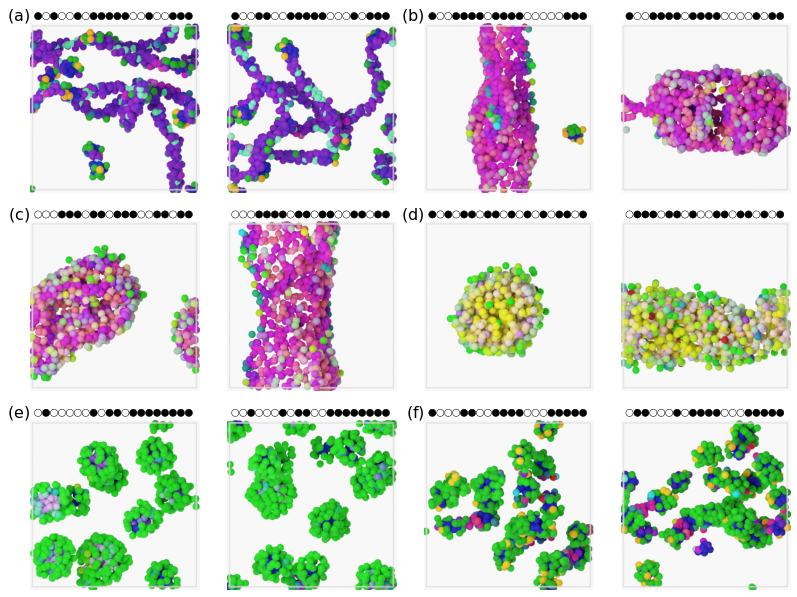

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import glob
import pandas as pd
import numpy as np
import os

drive_prefix = 'drive/Shareddrives/Polymers-Data'

key = 'archetypes'

pred_data = pd.read_csv(f'gru_{key}_preds.csv', index_col=0)
design_data = pd.read_csv(f'gru_{key}_md.csv', index_col=0)

# plot the targets
u, idx = np.unique(design_data['Target_ID'].values, return_index=True)
targets = design_data.iloc[idx, :].loc[:, ['Target_Z0', 'Target_Z1']].values

letters = 'abcdefghijklmnopqrstuvwxyz'
fig, axes = plt.subplots(len(targets)//2, 4, figsize=(7.48*1.5, 7.48*1.5*len(targets)/8))
axes = axes.flatten()

for ii, t in enumerate(targets):

    if key == 'archetypes':
        i = arch_order[ii]
    else:
        i = ii

    for k in range(2):
        if k == 0:
            loc_j = np.argmin(np.linalg.norm(t - design_data.loc[design_data['Target_ID']==ii, 'Z0':'Z1'].values, axis=1))
        else:
            loc_j = np.argmax(np.linalg.norm(t - design_data.loc[design_data['Target_ID']==ii, 'Z0':'Z1'].values, axis=1))

        j = np.arange(design_data.shape[0])[design_data['Target_ID']==ii][loc_j]

        s = design_data.iloc[j]['Sequence']
        
        ax = axes[(i*2)+k]

        directory_location = os.path.join(drive_prefix, 'trajectories', f'gru-cv-{key}-v2')
        
        # file_j = design_data.iloc[j].name
        # png_file = os.path.join(drive_prefix, directory_location, 'renders', f'spheres_{file_j:04d}_{s}.png')

        png_files = sorted(glob.glob(os.path.join(directory_location, 'renders', f'spheres_*_{s}.png')))
        loc_i = np.argwhere(design_data.loc[design_data['Sequence']==s].index == design_data.iloc[j].name).flatten()[0]
        png_file = png_files[loc_i]

        snapshot = np.array(Image.open(png_file))
        # alphas = np.all(snapshot[:, :, :3] >= 0.967 * 255, axis=2)
        # snapshot[alphas, :] = 0
        img = Image.fromarray(snapshot)

        ax.imshow(img)

        ax.set_axis_off()

        binseq = np.array([0 if x == 'A' else 1 for x in s])
        ax.scatter(np.arange(20)*24+24, np.zeros(20)-24, c=binseq, s=52,
                   cmap='Greys_r', linewidth=0.5, marker='o', edgecolors='k')
        # ymin, ymax = ax.get_ylim()
        # ax.set_ylim(ymin, ymax - 20)

        if k == 0:
            ax.text(0, -24, '$\mathrm{(%s)}$' % letters[i], ha="right", va="center", size=16)

plt.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout()

In [ ]:
fig.savefig(f'fig10-{key}.pdf', dpi=300)

# generate a sorted table (for ESI)

In [ ]:
# the order in the original 2021 paper:
# 0       1         2                  3       4                  5
# string, membrane, vesicle,           liquid, spherical micelle, wormlike micelle
# liquid, membrane, spherical micelle, string, vesicle,           wormlike micelle
# will use it like: arch_order[target_id]
# arch_order = [liquid, membrane, spherical micelle, string, vesicle, wormlike micelle]
arch_order = [3, 1, 4, 0, 2, 5]

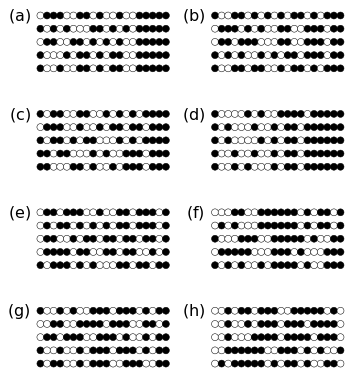

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

key = 'kmeans'

pred_data = pd.read_csv(f'gru_{key}_preds.csv', index_col=0)
design_data = pd.read_csv(f'gru_{key}_md.csv', index_col=0)

# plot the targets
u, idx = np.unique(design_data['Target_ID'].values, return_index=True)
targets = design_data.iloc[idx, :].loc[:, ['Target_Z0', 'Target_Z1']].values

letters = 'abcdefghijklmnopqrstuvwxyz'
xspace, yspace = (1.0, 2.0)
fig, axes = plt.subplots(len(targets)//2, 2, figsize=(5.0, 4.0*1.5*len(targets)/8))
axes = axes.flatten()

for ii, t in enumerate(targets):

    if key == 'archetypes':
        i = arch_order[ii]
    else:
        i = ii

    ax = axes[i]
    ax.set_axis_off()

    seq_u = np.unique(design_data.loc[design_data['Target_ID']==ii, 'Sequence'].values)

    avg_of_preds = np.zeros(len(seq_u))
    for k, seq in enumerate(seq_u):
        these_preds = design_data.loc[design_data['Sequence'] == seq, ['Z0', 'Z1', 'Target_ID']]
        avg_of_preds[k] = np.linalg.norm(t - these_preds.values[:, :2], axis=1).mean()

    loc_j = np.argsort(avg_of_preds)
    # loc_j = np.argsort(np.linalg.norm(t - design_data.loc[design_data['Target_ID']==i, 'Z0':'Z1'].values, axis=1))
    # ord_j = np.arange(design_data.shape[0])[design_data['Target_ID']==i][loc_j]
    # for j in ord_j:
    #     s = design_data.iloc[j]['Sequence']
    # ax.scatter(np.arange(20)*xspace+0.5, np.zeros(20)+yspace, c=np.ones(20))
    # ax.scatter(np.arange(20)*xspace+0.5, np.zeros(20)-yspace*(len(targets)-3), c=np.ones(20))
    for k, j in enumerate(loc_j):
        s = seq_u[j]

        binseq = np.array([0 if x == 'A' else 1 for x in s])
        ax.scatter(np.arange(20)*xspace+0.5, np.zeros(20)-k*yspace, c=binseq, s=48,
                cmap='Greys_r', linewidth=0.5, marker='o', edgecolors='k')
    # ymin, ymax = ax.get_ylim()
    # ax.set_xlim(0, 21)
    ax.set_ylim(-len(seq_u)*yspace, 1)
    ax.set_aspect('equal')

    ax.text(-1, 0, '$\mathrm{(%s)}$' % letters[i], ha="right", va="center", size=16)

plt.subplots_adjust(hspace=0.0, wspace=1.0)
fig.tight_layout()

In [ ]:
fig.savefig(f'esi-sequences-{key}.pdf', dpi=300)